In [1]:
%load_ext autoreload
%autoreload 2

from evaluation_scripts.base import load_json, get_base_pathes
import pandas as pd
import os
from evaluation_scripts.base import load_pickle_obj
from model_scripts.sensitivity_evaluation import ParameterSetEvaluation, SensitivityAnalysis
from model_scripts.kernel_collector import KernelCollector
import matplotlib.pyplot as plt
from model_scripts.lda_kernel_plotter import KernelPlot
from model_scripts.grid import GridPoint, MakeGrid

date = "16052023"
name_add = "_clean"
_, base = get_base_pathes()
path = os.path.join(base, "sensitivity_sim")

In [2]:
sensitivity = SensitivityAnalysis(path, parameter_names = ["turnover",
                                "infection", "cA", "cB", "cS", "cU", "cAB"], name_add = name_add)
reload = True
if reload:
    sensitivity.load()
else:
    sims = pd.read_pickle(os.path.join(path, "sensitivity_sim"+name_add+".pkl"))
    pars = pd.read_pickle(os.path.join(path, "sensitivity_par"+name_add+".pkl"))
    sensitivity.evaluate_parameter_sets(sims, pars)
sensitivity.lda()
sensitivity.join_eval_data()

In [3]:
import seaborn as sns
colors = dict(zip(sensitivity.strategies, sns.color_palette("pastel")))
text_placement_y = {"turnover":.02, "infection":-.04, "cA":-.02, "cB":.02, "cS":.04, "cU":-.04, "cAB":.03}


In [4]:
def plot_original_axes(ax, lda_directions, parameter_names, text_placement_y, arrow_length=0.75, adjust = 1, head_adjust = 0.01):
        for param in parameter_names:
            color = 'black'  # Set the color to black
            direction = lda_directions[param].values
            ax.arrow(0, 0, direction[0] * arrow_length, direction[1] * arrow_length,
                          head_width=head_adjust, head_length=head_adjust, fc=color, ec=color)
            
            ax.text(direction[0] * arrow_length * adjust, direction[1]
                         * arrow_length *adjust + text_placement_y[param], param, color=color, fontsize=15)

In [5]:
df = sensitivity.evaluations_df.sample(100)
df = sensitivity.evaluations_df

In [6]:
scenario1 = {
       "UI_mean":"Combo",
       "infection":0.3, 
       "turnover":.2,
       "cA":0.053,
       "cB":0.053,
       "cS":0.745,
       "cU":0.149,
       "cAB":0,
       "name":"Scenario1"}
scenario2 = {
       "UI_mean":"Combo",
       "infection":0.35,
       "turnover":0.2,
       "cA":0.106,
       "cB":0.106,
       "cS":0.586,
       "cU":0.149,
       "cAB":0.053,
       "name":"Scenario2"}
scenario3 = {
       "UI_mean":"Combo",
       "infection":0.25,
       "turnover":.5,
       "cA":0.5,
       "cB":0.5,
       "cS":0,
       "cU":0,
       "cAB":0,
       "name":"Scenario3"}
experiments = pd.DataFrame().from_dict([scenario1, scenario2, scenario3])
experiments


,UI_mean,infection,turnover,cA,cB,cS,cU,cAB,name
0,Combo,0.30,0.2,0.053,0.053,0.745,0.149,0.000,Scenario1
1,Combo,0.35,0.2,0.106,0.106,0.586,0.149,0.053,Scenario2
2,Combo,0.25,0.5,0.500,0.500,0.000,0.000,0.000,Scenario3


In [7]:
def get_lda_XY(lda_directions, df):
        cols = lda_directions.columns
        data = df[cols]
        pX = lda_directions.loc[0, ]
        pY = lda_directions.loc[1, ]
        df["ldaX"] = data.apply(lambda x: (x*pX).sum(), axis = 1)
        df["ldaY"] = data.apply(lambda x: (x*pY).sum(), axis = 1)
        return df
    
experiments = get_lda_XY(sensitivity.parameter_directions, experiments)
experiments

,UI_mean,infection,turnover,cA,cB,cS,cU,cAB,name,ldaX,ldaY
0,Combo,0.30,0.2,0.053,0.053,0.745,0.149,0.000,Scenario1,-0.020708,0.002098
1,Combo,0.35,0.2,0.106,0.106,0.586,0.149,0.053,Scenario2,-0.032885,0.093716
2,Combo,0.25,0.5,0.500,0.500,0.000,0.000,0.000,Scenario3,-0.523035,0.534576


In [8]:
def plot_experiments(ax, experiments, markersize = 500, edgecolors = "black", yspace = [0.03, 0.03, 0.03], xspace = [0, 0, 0]):
    sns.scatterplot(data=experiments, x="ldaX", y="ldaY", s = markersize, marker = "*",
            hue="UI_mean", alpha=1,  legend=False)
    for i, exp in experiments.iterrows():
        ldaX = exp["ldaX"]
        ldaY = exp["ldaY"]
        ax.text(ldaX + xspace[i], ldaY + yspace[i], exp["name"], color="black", fontsize=15)


In [9]:
df.winning_strategy.replace({"None":"No Winner"}, inplace = True)
colors.update({"No Winner":(0,0,0)})
colors

{'Combination': (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 'Cycling': (1.0, 0.7058823529411765, 0.5098039215686274),
 'Mixing': (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 'Mono A': (1.0, 0.6235294117647059, 0.6078431372549019),
 'Mono B': (0.8156862745098039, 0.7333333333333333, 1.0),
 'No treatment': (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 'No Winner': (0, 0, 0)}

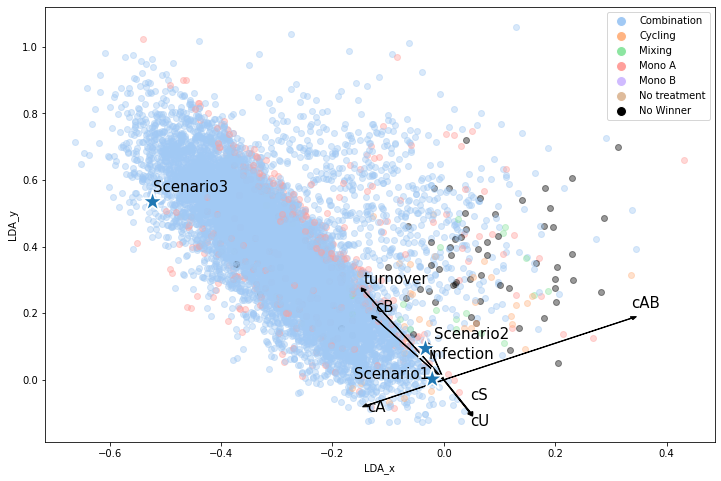

In [10]:
from random import random
fig, ax = plt.subplots(figsize = (12,8))

ldax, lday = df.LDA_axis_1[0::10], df.LDA_axis_2[0::10]
p = 1
counter = 0
for x, y in zip(ldax, lday):
    if p > random():
        counter += 1
        data = df[(df.LDA_axis_1 == x) & (df.LDA_axis_2 == y)]
        av_winner = data.winning_strategy.value_counts().idxmax()
        ax.scatter(x = x, y = y, color = colors[av_winner], marker = "o", alpha = 0.4)

plot_original_axes(ax, sensitivity.parameter_directions, sensitivity.parameter_names, text_placement_y, arrow_length=0.4)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in colors.items()]

plot_experiments(ax, experiments, yspace = [0., 0.03, 0.03], xspace = [-.14, .015, 0])
# Add the custom legend to the plot
plt.legend(handles=legend_elements, loc='upper right')
plt.xlabel("LDA_x")
plt.ylabel("LDA_y")
plt.savefig(os.path.join(path, "lda_raw"+name_add+".png"), dpi = 300)



In [12]:
vars(sensitivity.lda)

{}